# All settings will be given to the channel 1 output, in the DC Amp out configuration

In [1]:
%matplotlib widget 

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import pyvisa as visa
from matplotlib import animation
from time import sleep
from matplotlib.animation import FuncAnimation
#Importing the functions from the module and the pulses dictionaries
from Sweeping import *
from Dictionaries import *
from PulseFiles import *
from Instrument import *
import pyqtgraph as pg 
import nidaqmx

# Visa interface for the M8190A instrument:

In [3]:
M8190A = VisaR(AWG_Settings4,60000)

In [4]:
Initialization(M8190A,AWG_Settings4)

Instruments Sampling Frecuency set to 5.00000000000000E+08Hz
Instruments DC1 Output route Voltage set to 7.00000000000000E-01deciVolts
AWG set to TRIGGERED Mode
Trigger In threshold value set to 1.00000000000000E+00V


In [5]:
M8190A.query('*IDN?')

'Agilent Technologies,M8190A,MY57701776,5.6.0.0-2'

In [26]:
M8190A.write('*RST')

5

In [5]:
M8190A.query('FREQ:RAST?')

'5.00000000000000E+08'

In [7]:
M8190A.query('SYST:ERR?')

'0,"No error"'

In [4]:
print(M8190A)

TCPIPInstrument at TCPIP0::ibn3-036.ibn-net.kfa-juelich.de::hislip0::INSTR


# Loading and triggering a single waveform:

In [6]:
M8190A.query('ARM:TRIG:LEV?')

'1.00000000000000E+00'

In [6]:
M8190A.write('ABOR')

5

In [8]:
test_run0 = Sequence_Pulse_List(PList_secondsA,PList_secondsB,10,0,15,7500000,M8190A,AWG_Settings4,1)

Current Segment Catalogue is 1,7500000  [(segment id, Segment size)]
Current Segment Catalogue is 1,7500000,2,7500000  [(segment id, Segment size)]
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"


In [5]:
test_run = Triggered_Sequence_Setup(PList_secondsA,PList_secondsB,10,0,15,7500000,M8190A,AWG_Settings4,1)

Current Segment Catalogue is 1,7500000  [(segment id, Segment size)]
Current Segment Catalogue is 1,7500000,2,7500000  [(segment id, Segment size)]
Sequence advancement method is COND
Sequence loaded with the following segment data "1,1,0,1,0,7499999,2,1,0,1,0,7499999"


In [6]:
test_run[0]['Y1']*AWG_Settings4['Voltage Amplitude']

0            0.0
1          500.0
2          500.0
3          500.0
4          500.0
           ...  
7499995      0.0
7499996      0.0
7499997      0.0
7499998      0.0
7499999      0.0
Name: Y1, Length: 7500000, dtype: float64

In [7]:
test_run[1]['Y1']*AWG_Settings4['Voltage Amplitude']

0            0.0
1          500.0
2          500.0
3          500.0
4          500.0
           ...  
7499995      0.0
7499996      0.0
7499997      0.0
7499998      0.0
7499999      0.0
Name: Y1, Length: 7500000, dtype: float64

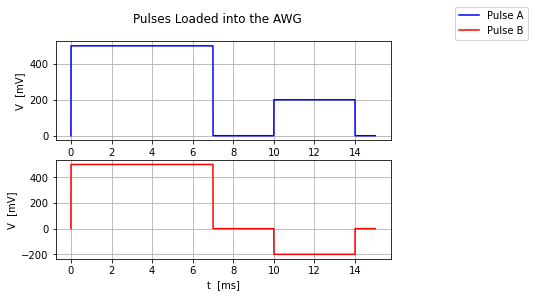

In [7]:
fig,ax= plt.subplots(2)

ax[0].grid(True)
ax[1].grid(True)
fig.suptitle('Pulses Loaded into the AWG')


ax[0].plot(test_run[2],test_run[0]['Y1']*AWG_Settings4['Voltage Amplitude'],label= 'Pulse A',color='blue')
ax[1].plot(test_run[2],test_run[1]['Y1']*AWG_Settings4['Voltage Amplitude'],label= 'Pulse B',color='red')
ax[0].set_ylabel('V  [mV]')
ax[0].set_xlabel('t  [ms]')
ax[1].set_ylabel('V  [mV]')
ax[1].set_xlabel('t  [ms]')

#ax.set_title('Pulses Loaded into the AWG')

fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('Pulse_sweep_t=20',optimize=True,bbox_inches='tight')

In [8]:
Trigger_Pulse('DAQBNC1','ao1',1.5,4)

Triggering Pulse Stoped


In [12]:
25*1e-3

0.025

In [22]:
DAQ_Settings1['Sampling Frequency'] * 25 *1e-3

10000.0

In [6]:
Trigger_Pulse('DAQBNC1','ao1',1.5,4)

Triggering Pulse Stoped


In [62]:
voltask =  nidaqmx.Task()

voltask.ao_channels.add_ao_voltage_chan("DAQBNC1/ao1",min_val=-3,max_val=3)





print('Task started')
voltask.start()

time.sleep(10)

print('Writting!')

time.sleep(4)
voltask.write(3)
time.sleep(7) 

print('Lowering Voltage!')
time.sleep(4)

voltask.write(0)
#
voltask.stop()
#
voltask.close()

Task started
Writting!
Lowering Voltage!


In [5]:
def DAQ_Measuring0(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      playingtime should be in seconds.
      triggerinvoltage should be in volts.
    """
    instrument.write('INIT:IMM')
    time.sleep(2)


    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime) 
    measuring_time = np.linspace(0,playingtime,samples)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
   


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

In [30]:
dataM, timeM = DAQ_Measuring0(DAQ_Settings1,1000,10,M8190A)

fig,ax= plt.subplots()

ax.grid(True)
#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(timeM,dataM*1000,label= '{b} samples'.format(b=len(dataM)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
ax.set_title('Voltage measured with DAQ, Amp out Channel')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement noise0',bbox_inches='tight')

Triggering Pulse Stoped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Different behaviour when initializing the AWG outside of the DAQ_measurement function (or inside, but with a time.sleep() right after it) and when initializing the AWG inside the function. Initializing with a delay gives "proper" measurement scheme (I still have to check whether it is getting the correct time scale). This independant of the delay time present when loading a waveform to the awg for the first time after reseting.

In [16]:
dataM.size

10000

In [6]:
def DAQ_Measuring0ms(DAQ_settings,sr,playingtime,instrument):
    """This function starts sets up the DAQ box in order to collect data for a time duration given by "playing time"
      It then uses the DAQ box to trigger the AWG into playing a waveform.

      playingtime should be in seconds.
      triggerinvoltage should be in volts.
    """
    instrument.write('INIT:IMM')
    time.sleep(2)



    #Calculating the number of samples given the samplig frecuency and playing time
    samples = int(sr * playingtime*1e-3) 
    measuring_time = np.linspace(0,playingtime,samples)

    #setting the tasks
    measuring_task = nidaqmx.Task()
    trig_task =  nidaqmx.Task()
   


    #Channels Configuration
    measuring_task.ai_channels.add_ai_voltage_chan("{a}/{b}".format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Input']),min_val=DAQ_settings['Minimum Voltage'],max_val= DAQ_settings['Maximum Voltage'])
    trig_task.ao_channels.add_ao_voltage_chan('{a}/{b}'.format(a = DAQ_settings['DAQ Name'], b = DAQ_settings['Analog Channel Output']),'triggering',-4,4)

    #Sampling configuration measuring channel
    measuring_task.timing.cfg_samp_clk_timing(sr, active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=samples)
    #trig_task.timing.cfg_samp_clk_timing(DAQ_settings['Sampling Frequency'], samps_per_chan=samples)
    #source = "measuring_task/SampleClock"

    trig_task.start()
    measuring_task.start()
    

    
    trig_task.write(1.5)
    #time.sleep(3)
    data = np.array(measuring_task.read(samples))


    
    #time.sleep(3)
    print('Triggering Pulse Stoped')
    trig_task.write(0)

    
    
    

    trig_task.stop()
    measuring_task.stop()

    measuring_task.close()
    trig_task.close()


    instrument.write('ABOR')

    return data, measuring_time

In [21]:
dataM, timeM = DAQ_Measuring0ms(DAQ_Settings1,400000,32,M8190A)

fig,ax= plt.subplots()

ax.grid(True)
#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(timeM,dataM*1000,label= '{b} samples'.format(b=len(dataM)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Voltage measured with DAQ, Direct out Channel DAC')
ax.legend(loc=0)
#plt.legend(bbox_to_anchor=(2.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement timeoffset2',bbox_inches='tight')

Triggering Pulse Stoped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
M8190A.query('OUTP:ROUT:SEL?')

'DAC'

In [17]:
M8190A.write('INIT:IMM')

9

Triggering Pulse Stoped


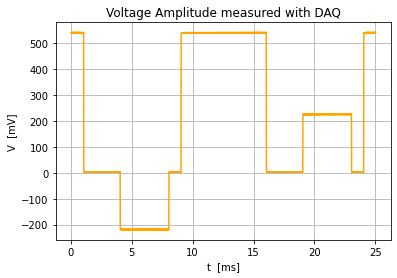

In [10]:
dar,tar = DAQ_Measuringt(DAQ_Settings1,25,1.5)

fig,ax= plt.subplots()

ax.grid(True)
#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(tar,dar*1000,label= '{b} samples'.format(b=len(dar)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Voltage Amplitude measured with DAQ')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement',bbox_inches='tight')

In [ ]:
DAQ_Settings3 = {
    'DAQ Name' : 'DAQBNC1',
    'Analog Channel Input' : 'ai0',
    'Analog Channel Output' : 'ao1',
    'Minimum Voltage' : -4,
    'Maximum Voltage' : 4,
    'Sampling Frequency' : 1000,
    'Data Directory': r'D:\Documentos\STM\Python Pulses\S1'

In [ ]:
with nidaqmx.Task() as ai_task, nidaqmx.Task() as ao_task:
    rate = 10**4 # sample rate in Hz
    duration = 1 # acquisition duration in seconds 
    npnts = int(rate * duration)
    ai_task.ai_channels.add_ai_voltage_chan('Dev2/ai0')
    ao_task.ao_channels.add_ao_voltage_chan('Dev2/ao0')
    ao_task.timing.cfg_samp_clk_timing(rate,
                                     sample_mode=AcquisitionType.FINITE,
                                     samps_per_chan=npnts)
    ai_task.timing.cfg_samp_clk_timing(rate, source='ao/SampleClock', samps_per_chan=npnts)
   
    ao_task.write(np.linspace(-1, 1, npnts), auto_start=False)
    ao_task.start()
    ai_task.start()
    
    ai_task.wait_until_done()
    ao_task.wait_until_done()
    
    data = ai_task.read(number_of_samples_per_channel=npnts)

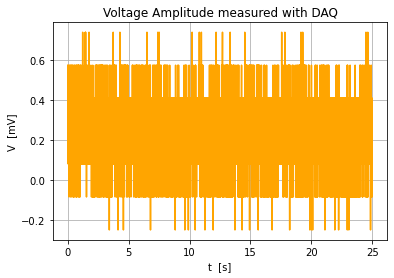

In [4]:
dar,tar = DAQ_Measuring0(DAQ_Settings1,25,1.5,M8190A)

fig,ax= plt.subplots()

ax.grid(True)
#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(tar,dar*1000,label= '{b} samples'.format(b=len(dar)),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [s]')
ax.set_title('Voltage Amplitude measured with DAQ')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement',bbox_inches='tight')

In [10]:
10/(2**14)

0.0006103515625

In [29]:
M8190A.write('SEQ:ADV 0, COND')

16

In [16]:
M8190A.query('SEQ:ADV? 0')

'COND'

In [11]:
M8190A.write('SEQ:ADV 0, AUTO')

16

In [28]:
M8190A.write('ABOR')

5

There is something weird while initiating the function before setting up the DAQ

In [21]:
from nidaqmx.constants import Edge
from nidaqmx.constants import AcquisitionType


n = 10000

task = nidaqmx.Task()

task.ai_channels.add_ai_voltage_chan("DAQBNC1/ai0",min_val=-4,max_val=4)
task.timing.cfg_samp_clk_timing(400000, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=n)


task.start()



data_on = np.array(task.read(n))



task.stop()
task.close


tom = np.linspace(0,25,n)


fig,ax= plt.subplots()

ax.grid(True)
#plt.plot(tom,data_off,label= 'AWG off')
plt.plot(tom,data_on*1000,label= '{b} samples'.format(b=n),color='orange')

ax.set_ylabel('V  [mV]')
ax.set_xlabel('t  [ms]')
ax.set_title('Voltage Amplitude measured with DAQ')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
#fig.savefig('DAQ measurement',bbox_inches='tight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …